[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GoekeLab/sg-nex-data/blob/CDM5104_RNASeq/docs/colab/SG_NEx_Bambu_tutorial_notebook.ipynb)



# **Transcript discovery and quantification using Bambu for long read RNA-sequencing samples**

In this tutorial, we will perform novel transcript discovery and
quantification on the SG-NEx samples. We will be using six Nanopore direct RNA-Sequencing
samples, with three replicates each from the A549 and
HepG2 cell lines. The A549 cell line was extracted from lung tissues
of a patient with lung cancer whereas HepG2 was extracted from
hepatocellular carcinoma of a patient with liver cancer. We will use
[Bambu](http://bioconductor.org/packages/bambu/), a R package hosted on the Bioconductor platform to identify and
quantify novel isoforms in these cell lines.

**Note: This tutorial may take 10 minutes to complete. The installation of Bambu on this notebook may take up to 20 minutes. If you have bambu installed locally, you can also copy the commands to run it locally.**


## **Content**

- [Installation](#installation)
- [Data Access and Preparation](#data-access-and-preparation)
- [Running Bambu](#running-bambu)
- [Reference](#reference)


## **Installation**

To install **bambu**, make sure you have **R** (version >= 4.2) installed on your machine. Then you can install **bambu** using the following commands:

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("bambu", update = FALSE)

Note the above step takes about 17 mins.

In [ ]:
## later we will need to do some plotting. which require some plotting packages
BiocManager::install("ggbio")
BiocManager::install("ggplot2")
BiocManager::install("gridExtra")
BiocManager::install("circlize")
BiocManager::install("ComplexHeatmap")
BiocManager::install("grid")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.21), R 4.3.1 (2023-06-16)

Installing package(s) 'ggbio'

also installing the dependencies ‘checkmate’, ‘htmlwidgets’, ‘plyr’, ‘htmlTable’, ‘viridis’, ‘Formula’, ‘dichromat’, ‘graph’, ‘RBGL’, ‘reshape’, ‘ProtGenerics’, ‘lazyeval’, ‘gridExtra’, ‘reshape2’, ‘Hmisc’, ‘biovizBase’, ‘VariantAnnotation’, ‘OrganismDbi’, ‘GGally’, ‘ensembldb’, ‘AnnotationFilter’




Note the steps above take about 7 mins.

In [ ]:
# For post-bambu downstream analysis, we will need the following packages.
BiocManager::install("DESeq2", update = FALSE)
BiocManager::install("apeglm", update = FALSE)
BiocManager::install("DEXSeq", update = FALSE)

Note that the above steps take about 5 mins

If you want a more recent version of Bambu, you may refer to the [Bambu Github repository](https://github.com/GoekeLab/bambu). Note that if you are running command locally with **bambu** pre-installed, you may skip this section.


## **Data Access and Preparation**





Generally, you may want to learn how to get access to these data using the [data
access
tutorial](AWS_data_access_tutorial.md). Below we only show the necessary steps to download the required data. The following command requires you to have [AWS CLI](https://aws.amazon.com/cli/) installed.

But for this tutorial, we provide another approach to use *AWS CLI* within *R*

In [1]:
# install AWS for R
install.packages("aws.s3")
# set region for AWS
Sys.setenv("AWS_DEFAULT_REGION" = 'ap-southeast-1')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### **Download reference genome and annotations**

The default mode to run Bambu is using a set of aligned reads (bam files), reference genome annotations (gtf file, TxDb object, or bambuAnnotation object), and reference genome sequence (fasta file or BSgenome). Here we use the ensembl GRCh 38 genome sequence and annotation files, which we have downloaded and stored in the SG-NEx data open S3 bucket.

In [2]:
# create a directory to store the data
#dir.create("bambu_tutorial")
#setwd("./bambu_tutorial") # if running locally good habit to do this 

Warning message in dir.create("bambu_tutorial"):
“'bambu_tutorial' already exists”


In [4]:
# download genome fasta file
aws.s3::save_object(
  object="data/data_tutorial/annotations/hg38_chr22.fa",
  bucket="sg-nex-data",
  region="ap-southeast-1",
  file="hg38_chr22.fa")
# download genome index fastai file
aws.s3::save_object(
  object="data/data_tutorial/annotations/hg38_chr22.fa.fai",
  bucket="sg-nex-data",
  region="ap-southeast-1",
  file="hg38_chr22.fa.fai")
# download gtf file
aws.s3::save_object(
  object="data/data_tutorial/annotations/hg38_chr22.gtf",
  bucket="sg-nex-data",
  region="ap-southeast-1",
  file="hg38_chr22.gtf")

[1] "hg38_chr22.fa"

[1] "hg38_chr22.fa.fai"

[1] "hg38_chr22.gtf"

### **Download raw fastq file and perform alignment**

The SG-NEx project provides aligned reads that can be used directly with Bambu, however sometimes, raw fastq reads might be provided instead of aligned reads.

In [5]:
fastq_list=c("A549_directRNA_sample1.fastq.gz",
           "A549_directRNA_sample2.fastq.gz",
           "A549_directRNA_sample3.fastq.gz",
           "HepG2_directRNA_sample1.fastq.gz",
           "HepG2_directRNA_sample2.fastq.gz",
           "HepG2_directRNA_sample3.fastq.gz")
for (fastq in fastq_list[1]){ # here we try with one sample
  aws.s3::save_object(
    object=paste0("data/data_tutorial/fastq/",fastq),
    bucket = "sg-nex-data",
    region="ap-southeast-1",
    file=basename(fastq))
}

In [6]:
# visualizing fastq file
system("zcat A549_directRNA_sample1.fastq.gz | head -8", intern = TRUE)

[1] "@a041389b-3e9d-45ce-8f99-f30642354559"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
[2] "CTCGGAAGCGGTGCACCCAGAGGCGGTCCTGTAGCCGGGCAAGCACTGGGCTTTGGTTTATGTCCCTGCGGTCGGTGCAAAGGGCGAAGAGGAACCCTTGGGCCGGGGAAACGCCGGGCCGGGCCAGTGACACACCCTCCCTAGTTGTGGGAGCAGACGCGTGGGCCATTGCGGGCGGGCAGGCCTGAAGTGCAGCTATCGTTCAGTGTCCTTGGGTGTTCCAAGAGCAACAAGAAACGAAATAAATCTCTGTTGAAGATACCATTTGACTTTTAGAGATGGCTGTATGCAAACTCTGAAACATTGAATTCACTTCTGCAGTTTCCACAGAAGTCTCCAATCACAATTTCAGTGTATGAAAGCACAGATTCCTGAAAGAATGGCCTCTCAAATGAGACTCCAGGAGTGGGAGCTTACCGTTATCCCTGCTCCTGAAAAACAAGCTAACTGGAAGTTCCATTCACCTGCCACCAGCAACGTTACCACTACACTACCCATTGAACTACCTTCGGTTGATCTGCCAGCTAATTCATGCCCCTGACCCAGCCCACATGGCTTTGGGAAGGACATTCAGTGAACTGTGAAAGAGACCGGAGATTCACTCTGTTGCCAGGCATTGGAGTGCAATGGCACAATTTCGGCTATCCACAATTTCTGTCTCCCCAGATCAAGCTATTTACCTCTGCCACTGTACCCCTAAGGAGAATAAAGGACTACAGATGAAGCACCATTAACGTAGACAGAAGAGCACAAAGTCAAACCTTTGTTGTCGAAGCGTCTTACGAGTCCATCACAAACTGTTCACAAAAATATGAAACCCAGGCAAAGGTTCAGACATACGACGTTTGTTTTAAAATCACCTTTACAGCCTTGTATACCTTACCTTTTAAAATGTGTTATGAGTTTTATTTAGACTAACATCATACGATTAATTGATACGCCAGTATTCAGTTGCTGTGTTTGATGAATCAAATGGTAAATCAATTTGTGTACTTTAATAAAGTATATCGAATGCAAAATCCCCACCCCATCCCACCATTCATATCCATTCCCCCATCTACCATCCCAAAATCCTTCCAGG"                                                                                                   
[3] "+"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
[4] "##&'(*')%&)()))4/+(&(*,)-.-21,**++,),.,),+*(&%$$*,')&-70++*').0)61('%))'(*-+0.11/'72'+,-**,.-0,--.+)**(%$(**)+(&#(*)1/((-1*1/),,,(,.+(//&%-5,&&/1,,,14,)))**+/(&(%(+,*'(/+,*)36&&).\"$&,(/)-+*')*++/0.)($%%&($+2-+2((-+40)')'+*21../0-0+,0'*0('*+9-,090+',+*+)+(..12..2-**.4,1,(/-&)'(**,*-++*))*-/9<3**&/,/7.*),2&,7'+%$$&,$()((-26(0+(&))'0''%'23-9)%#)*++**'/012129),2.'((**0.4+/---08/)0,$(,+,''')05-,'%%&&$/(&.*''%&*.)*%%$#&-(.0--343-1*)*()

 In that case, alignment must be done first and can be done as follows:

In [30]:
# install minimap2
cat(system("curl -L https://github.com/lh3/minimap2/releases/download/v2.26/minimap2-2.26_x64-linux.tar.bz2 | tar -jxvf - ", intern = TRUE), sep = "\n")
cat(system("./minimap2-2.26_x64-linux/minimap2 --version", intern = TRUE), sep = "\n")

minimap2-2.26_x64-linux/
minimap2-2.26_x64-linux/FAQ.md
minimap2-2.26_x64-linux/minimap2
minimap2-2.26_x64-linux/README.md
minimap2-2.26_x64-linux/NEWS.md
minimap2-2.26_x64-linux/LICENSE.txt
minimap2-2.26_x64-linux/k8
minimap2-2.26_x64-linux/paftools.js
minimap2-2.26_x64-linux/cookbook.md
minimap2-2.26_x64-linux/minimap2.1
minimap2-2.26_x64-linux/README-js.md


Warning message in system("./minimap2-2.26_x64-linux/minimap2", intern = TRUE):
“running command './minimap2-2.26_x64-linux/minimap2' had status 1”


In [24]:
# install samtools
cat(system("sudo apt install samtools", intern = TRUE), sep = "\n")

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
  [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
  [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
  [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
  [5] "  cwltool fonts-glyphicons-halflings libc-ares2 libhts3 libjs-bootstrap"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
  [6] "  libnode64 nodejs nodejs-doc python3-bs4 python3-cachecontrol"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
  [7] "  python3-coloredlogs python3-dateutil python3-decorator python3-html5lib"                                       

In [25]:
cat(system("samtools --version-only", intern = TRUE), sep = "\n")

[1] "samtools 1.10"                          
[2] "Using htslib 1.10.2-3ubuntu0.1"         
[3] "Copyright (C) 2019 Genome Research Ltd."

In [46]:
cat(system("./minimap2-2.26_x64-linux/minimap2 -ax splice -uf -k14 hg38_chr22.fa A549_directRNA_sample1.fastq.gz > A549_directRNA_sample1_test.sam ", intern = TRUE), sep = "\n")

In [47]:
cat(system("samtools view -Sb A549_directRNA_sample1_test.sam | samtools  sort -o A549_directRNA_sample1_test.bam ", intern = TRUE), sep = "\n")

In [50]:
cat(system("samtools index A549_directRNA_sample1_test.bam", intern = TRUE), sep = "\n")

***Note that we are aligning the reads to the genome fasta and not the transcriptome fasta as `Bambu` uses intron junctions to distinguish novel transcripts.***

### **Or download data for bambu directly**
Next, we will need to download the required data to run Bambu. The required data include:

-   a set of aligned reads to the genome from the A549 and HepG2 cell lines (bam files),
-   reference human genome annotations (gtf file, TxDb object, or Bambu
    Annotation object),
-   reference human genome sequence (fasta file or BSgenome).



In [ ]:
# download aligned bam files for A549 samples and HepG2 samples
bam_list=c("A549_directRNA_sample1.bam",
           "A549_directRNA_sample2.bam",
           "A549_directRNA_sample3.bam",
           "HepG2_directRNA_sample1.bam",
           "HepG2_directRNA_sample2.bam",
           "HepG2_directRNA_sample3.bam")
for (bam in bam_list){
  aws.s3::save_object(
    object=paste0("data/data_tutorial/bam/",bam),
    bucket = "sg-nex-data",
    region="ap-southeast-1",
    file=basename(bam))
}

In [ ]:
# just had a quick check at the generated files, sligh change in bam file size might be due to minimap2 version
file.size("A549_directRNA_sample1_test.bam")
file.size("A549_directRNA_sample1.bam")

**NOTE: We have downsampled the Hg38 genome, A549 and HepG2 samples to ensure this tutorial can be completed in 10 minutes. If you want to run Bambu on the original samples, you can find the sample name [here](https://github.com/GoekeLab/sg-nex-data/blob/master/docs/samples.tsv) and amend it into the following code chunk:**

In [ ]:
# Do not run unless you have specified the sample_alias with the sample of interest in the SG-NEx bukcet as recommended.
aws.s3::save_object(
  object="data/sequencing_data_ont/bam/genome/<sample_alias>",
  bucket="sg-nex-data",
  region="ap-southeast-1",
  file="<sample_alias>")

### **Quality control**
***Samtools stats*** can be used to quickly check the read accuracy and read mappability in the bam files, in the example below, we checked the aligned bam file for the SGNex_A549_directRNA_replicate1_run1 sample.

In [ ]:
cat(system("samtools stats A549_directRNA_sample1.bam | head -46 ", intern = TRUE), sep = "\n")

# This file was produced by samtools stats (1.10+htslib-1.10.2-3ubuntu0.1) and can be plotted using plot-bamstats
# This file contains statistics for all reads.
# The command line was:  stats A549_directRNA_sample1_test.bam
# CHK, Checksum	[2]Read Names	[3]Sequences	[4]Qualities
# CHK, CRC32 of reads which passed filtering followed by addition (32bit overflow)
CHK	7864bfd0	9e953de0	1b38e0b4
# Summary Numbers. Use `grep ^SN | cut -f 2-` to extract this part.
SN	raw total sequences:	6890
SN	filtered sequences:	0
SN	sequences:	6890
SN	is sorted:	1
SN	1st fragments:	6890
SN	last fragments:	0
SN	reads mapped:	6889
SN	reads mapped and paired:	0	# paired-end technology bit set + both mates mapped
SN	reads unmapped:	1
SN	reads properly paired:	0	# proper-pair bit set
SN	reads paired:	0	# paired-end technology bit set
SN	reads duplicated:	0	# PCR or optical duplicate bit set
SN	reads MQ0:	4	# mapped and MQ=0
SN	reads QC failed:	0
SN	non-primary alignments:	131
SN	total length:	7228225	# ignores

This bam file has a read mappability of `6890/6890 (100%)` by taking the ratio between reads mapped and raw total sequences and a read accuracy of `1-0.1803308 (0.819%)` by minusing 1 with the error rate. Usually we consider a sample with a mappability of 80% above as relatively good, and the read accuracy is also common for Nanopore reads.

### **Preparing data for ***Bambu*****

All required data are now stored in the `bambu_tutorial` folder of the
current working directory. Next, we prepare the data to run Bambu.

In [ ]:
# set work directory if you are in a different directory
# setwd("bambu_tutorial")

# data preparation
library(bambu)
fa.file <- "hg38_chr22.fa"
gtf.file <- "hg38_chr22.gtf"
annotations <- prepareAnnotations(gtf.file) # This function creates a reference annotation object which is used for transcript discovery and quantification in Bambu.
samples.bam <- list.files(".", pattern = "[0-9].bam$", full.names = TRUE) # the pattern is to exclude the duplicated test bam file generated by ourself

## **Running Bambu**

Now we can run Bambu with these data. For a
faster running speed, you can increase the `ncore` parameter up
to the total number of samples at your availability.

In [ ]:
# before running commands, good to check if file all exists 
file.exists(fa.file)
file.exists(gtf.file)
print(samples.bam)

In [ ]:
# running Bambu
se <- bambu(reads = samples.bam, annotations = annotations, genome = fa.file, ncore = 2)

WARNING - If you change the number of cores (ncore) between Bambu runs and there is no progress please restart your R session to resolve the issue that originates from the XGboost package.

--- Start generating read class files ---

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com



  |                                                                      |   0%

Warning message:
"There was 1 warning in `filter()`.
ℹ In argument: `newGeneId == min(newGeneId)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf"
Warning message:
"There was 1 warning in `summarise()`.
ℹ In argument: `intersectWidth = max(intersectWidth)`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf"
Warning message:
"There was 1 warning in `filter()`.
ℹ In argument: `newGeneId == min(newGeneId)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf"
Warning message:
"There was 1 warning in `summarise()`.
ℹ In argument: `intersectWidth = max(intersectWidth)`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf"
Warning message:
"There was 1 warning in `filter()`.
ℹ In argument: `newGeneId == min(newGeneId)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf"


  |===================================                                   |  50%

Warning message:
"There was 1 warning in `summarise()`.
ℹ In argument: `intersectWidth = max(intersectWidth)`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf"
Warning message:
"There was 1 warning in `filter()`.
ℹ In argument: `newGeneId == min(newGeneId)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf"
Warning message:
"There was 1 warning in `filter()`.
ℹ In argument: `newGeneId == min(newGeneId)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf"
Warning message:
"There was 1 warning in `filter()`.
ℹ In argument: `newGeneId == min(newGeneId)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf"
Warning message:
"There was 1 warning in `filter()`.
ℹ In argument: `newGeneId == min(newGeneId)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf"
Warning message:
"There was 1 warning in `summarise()`.
ℹ In argument: `intersectWidth = max

  |======================================================================| 100%



Detected 15 warnings across the samples during read class construction. Access warnings with metadata(bambuOutput)$warnings

--- Start extending annotations ---

Warning message:
"There was 1 warning in `summarise()`.
ℹ In argument: `intersectWidth = max(intersectWidth)`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf"
Warning message:
"There was 1 warning in `filter()`.
ℹ In argument: `newGeneId == min(newGeneId)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf"
Using a novel discovery rate (NDR) of: 0.129

--- Start isoform quantification ---

Warning message:
"There was 1 warning in `filter()`.
ℹ In argument: `newGeneId == min(newGeneId)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf"
Warning message:
"There was 1 warning in `filter()`.
ℹ In argument: `newGeneId == min(newGeneId)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf"
Warning message:
"There w

Note the above step takes about 2 mins to run.

Bambu returns a `SummarizedExperiment` object with the genomic
coordinates of the annotated & novel transcripts and their expression
estimates. They can be assessed using the following code:

In [ ]:
assays(se) #returns the transcript abundance estimates as counts or CPM.

List of length 4
names(4): counts CPM fullLengthCounts uniqueCounts

In [ ]:
head(assays(se)$counts)

,A549_directRNA_sample1,A549_directRNA_sample2,A549_directRNA_sample3,HepG2_directRNA_sample1,HepG2_directRNA_sample2,HepG2_directRNA_sample3
BambuTx1,2.00000,0.00000,0.00000,1.0,0.00000,0
BambuTx2,2.00000,30.33452,10.76898,13.0,0.00000,0
BambuTx3,4.64865,37.47735,24.52301,11.8,2.57143,0
BambuTx4,2.27273,3.22869,1.08501,0.0,0.00000,0
BambuTx5,2.00000,35.00000,11.00000,4.0,0.00000,1
BambuTx6,2.00000,23.00000,4.80000,2.0,1.00000,0


In [ ]:
rowRanges(se) #returns a GRangesList (with genomic coordinates) with all annotated and newly discovered transcripts.

GRangesList object of length 4547:
$BambuTx1
GRanges object with 3 ranges and 2 metadata columns:
      seqnames            ranges strand | exon_rank exon_endRank
         <Rle>         <IRanges>  <Rle> | <integer>    <integer>
  [1]       22 15784968-15785057      + |         1            3
  [2]       22 15788820-15788931      + |         2            2
  [3]       22 15852990-15853424      + |         3            1
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

$BambuTx2
GRanges object with 7 ranges and 2 metadata columns:
      seqnames            ranges strand | exon_rank exon_endRank
         <Rle>         <IRanges>  <Rle> | <integer>    <integer>
  [1]       22 15784971-15785057      + |         1            7
  [2]       22 15787172-15787282      + |         2            6
  [3]       22 15788552-15788699      + |         3            5
  [4]       22 15788820-15788931      + |         4            4
  [5]       22 15790661-15790798      + |        

In [ ]:
rowData(se) #returns additional information about each transcript such as the gene name and the class of the newly discovered transcript.

DataFrame with 4547 rows and 11 columns
                         TXNAME          GENEID        NDR novelGene
                    <character>     <character>  <numeric> <logical>
BambuTx1               BambuTx1 ENSG00000223875 0.00632911     FALSE
BambuTx2               BambuTx2 ENSG00000206195 0.11159737     FALSE
BambuTx3               BambuTx3 ENSG00000070010 0.01312336     FALSE
BambuTx4               BambuTx4 ENSG00000128185 0.03818616     FALSE
BambuTx5               BambuTx5 ENSG00000272779 0.00354610     FALSE
...                         ...             ...        ...       ...
ENST00000641859 ENST00000641859 ENSG00000284633         NA     FALSE
ENST00000641915 ENST00000641915 ENSG00000284665         NA     FALSE
ENST00000641933 ENST00000641933 ENSG00000284651         NA     FALSE
ENST00000641967 ENST00000641967 ENSG00000284630         NA     FALSE
ENST00000642075 ENST00000642075 ENSG00000284633         NA     FALSE
                novelTranscript     txClassDescription readCoun

This `SummarizedExperiment` object can also be used for further downstream analysis (eg. [DESeq](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)). If you want to save the transcript &  genomic annotations and their expression
estimates, you can then write them into an `output` folder using the `writeBambuOutput` function.

In [ ]:
writeBambuOutput(se, path = "./output")

The files in the `output` folder is described below:

| Output file name                | Description                                                             |
|:----------------------------|:------------------------------------------|
| extended_annotations.gtf        | Extended transcript & gene annotations for the genome using long reads data.        |
| counts_transcript.txt           | Total read counts estimates for each transcript in each sample.        |
| CPM_transcript.txt              | Counts per million (CPM) estimates for each transcript in each sample. |
| fullLengthCounts_transcript.txt | Full length read counts estimates for each transcript in each sample.  |
| uniqueCounts_transcript.txt                | Unique read counts estimates for each transcript in each sample.       |
| counts_gene.txt                 | Gene read counts estimates for each transcript in each sample.         |

**NOTE: This is a short tutorial to demonstrate the usage of Bambu on the SG-NEx data. Please refer to the [Bambu documentation](https://github.com/GoekeLab/bambu) for a more complete workflow in novel transcript discovery and quantification.**

## **Identifying sample-specific novel transcripts**
Now let's find some novel transcripts that occur uniquely in A549 but not in HepG2 and visualise them. First we will filter the annotations to remove the reference annotations. Then we can sort them by the `txNDR`, which ranks them by how likely they are a real transcript.

Firstly, novel transcripts in novel genes:



DataFrame with 2 rows and 11 columns
               TXNAME      GENEID       NDR novelGene novelTranscript
          <character> <character> <numeric> <logical>       <logical>
BambuTx47   BambuTx47  BambuGene1 0.0201005      TRUE            TRUE
BambuTx48   BambuTx48  BambuGene3 0.0314770      TRUE            TRUE
          txClassDescription readCount relReadCount relSubsetCount      txid
                 <character> <integer>    <numeric>      <numeric> <integer>
BambuTx47    newGene-spliced         2            1              1        47
BambuTx48    newGene-spliced         2            1              1        48
            eqClassById
          <IntegerList>
BambuTx47            47
BambuTx48            48

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.21), R 4.3.1 (2023-06-16)

Installing package(s) 'ggbio'

also installing the dependencies ‘checkmate’, ‘htmlwidgets’, ‘plyr’, ‘htmlTable’, ‘viridis’, ‘Formula’, ‘dichromat’, ‘graph’, ‘RBGL’, ‘reshape’, ‘ProtGenerics’, ‘lazyeval’, ‘gridExtra’, ‘reshape2’, ‘Hmisc’, ‘biovizBase’, ‘VariantAnnotation’, ‘OrganismDbi’, ‘GGally’, ‘ensembldb’, ‘AnnotationFilter’


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[[1]]
TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name               grob
1 1 (2-2,1-1) arrange     gtable[layout]
2 2 (3-3,1-1) arrange     gtable[layout]
3 3 (1-1,1-1) arrange text[GRID.text.98]


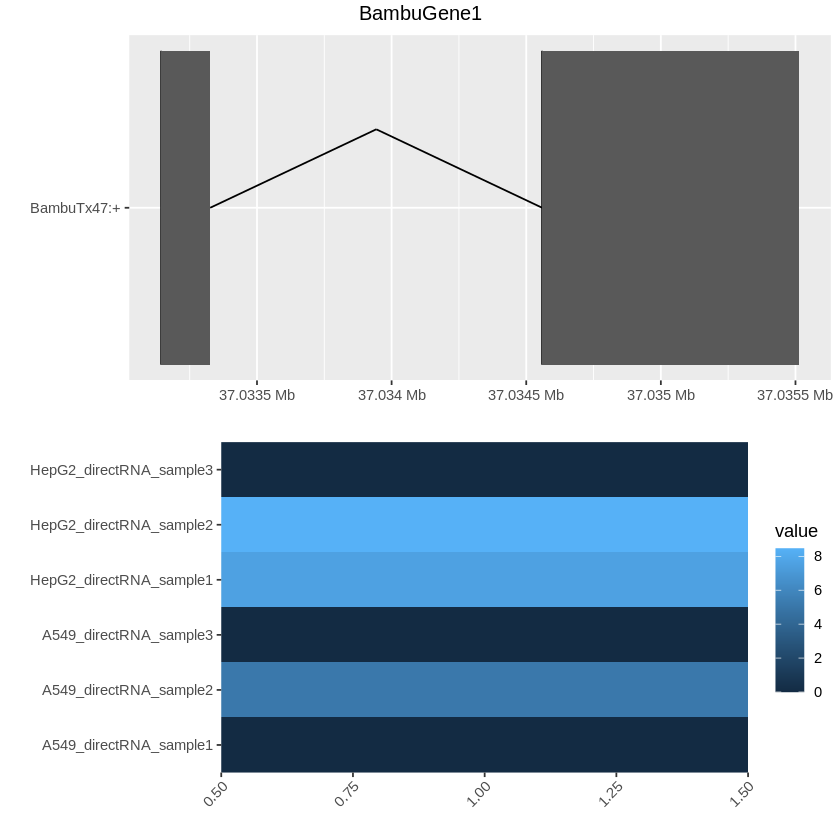

In [ ]:
se.filtered <- se[mcols(rowRanges(se))$novelTranscript == TRUE,]
#investigate high confidence novel isoforms
head(mcols(rowRanges(se.filtered))[order(mcols(rowRanges(se.filtered[]))$NDR),])


plotBambu(se, type = "annotation", gene_id = "BambuGene1")

DataFrame with 2 rows and 11 columns
               TXNAME      GENEID       NDR novelGene novelTranscript
          <character> <character> <numeric> <logical>       <logical>
BambuTx47   BambuTx47  BambuGene1 0.0201005      TRUE            TRUE
BambuTx48   BambuTx48  BambuGene3 0.0314770      TRUE            TRUE
          txClassDescription readCount relReadCount relSubsetCount      txid
                 <character> <integer>    <numeric>      <numeric> <integer>
BambuTx47    newGene-spliced         2            1              1        47
BambuTx48    newGene-spliced         2            1              1        48
            eqClassById
          <IntegerList>
BambuTx47            47
BambuTx48            48

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.21), R 4.3.1 (2023-06-16)

Installing package(s) 'ggbio'

also installing the dependencies ‘checkmate’, ‘htmlwidgets’, ‘plyr’, ‘htmlTable’, ‘viridis’, ‘Formula’, ‘dichromat’, ‘graph’, ‘RBGL’, ‘reshape’, ‘ProtGenerics’, ‘lazyeval’, ‘gridExtra’, ‘reshape2’, ‘Hmisc’, ‘biovizBase’, ‘VariantAnnotation’, ‘OrganismDbi’, ‘GGally’, ‘ensembldb’, ‘AnnotationFilter’


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[[1]]
TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name               grob
1 1 (2-2,1-1) arrange     gtable[layout]
2 2 (3-3,1-1) arrange     gtable[layout]
3 3 (1-1,1-1) arrange text[GRID.text.98]


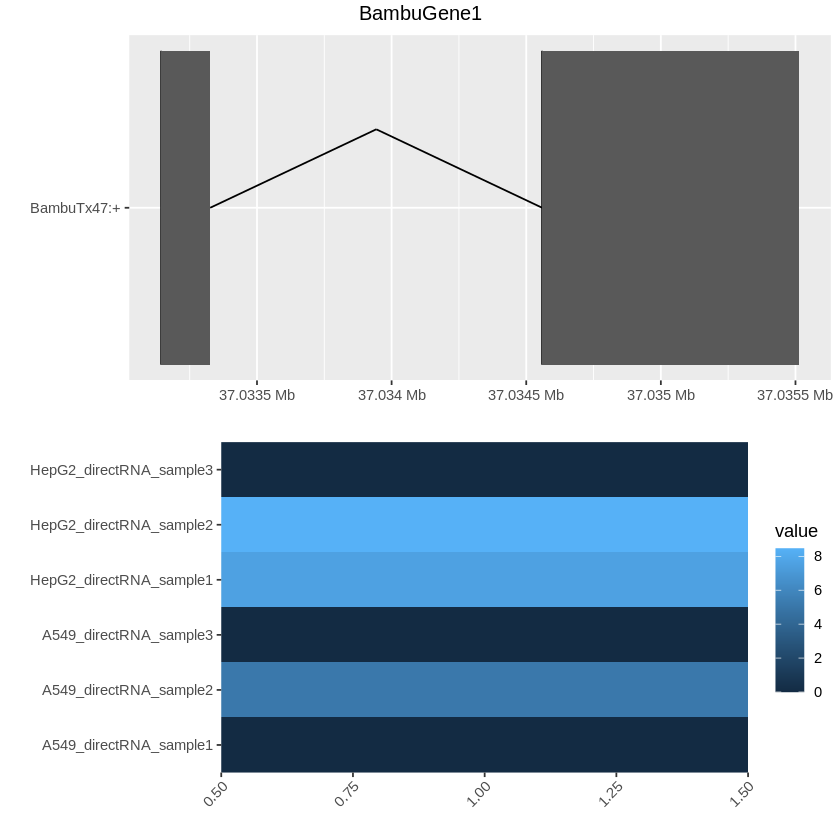

In [ ]:
# For post-bambu downstream analysis, we will need the following packages.
BiocManager::install("DESeq2", update = FALSE)
BiocManager::install("apeglm", update = FALSE)
BiocManager::install("DEXSeq", update = FALSE)

Or novel transcripts in annotated genes

In [ ]:
se.filtered.noNovelGene <- se.filtered[rowData(se.filtered)$novelGene == FALSE,]
head(mcols(rowRanges(se.filtered.noNovelGene))[order(mcols(rowRanges(se.filtered.noNovelGene))$NDR),])

plotBambu(se, type = "annotation", gene_id = "ENSG00000272779")

If we want to find out the ones that are unique based on counts

In [ ]:
#find which ones are unique based on counts
expression.A549 <- apply(assays(se.filtered)$counts[,grep("A549",colnames(se.filtered))],1,mean)
expression.HepG2 <- apply(assays(se.filtered)$counts[,grep("HepG2",colnames(se.filtered))],1,mean)


se.filtered[expression.A549>=1 &(expression.HepG2==0)] # unique in A549
se.filtered[expression.A549==0 &(expression.HepG2>=1)] # unique in HepG2

## UCSC browser visualization

We can visualise these novel transcripts using a genome browser such as IGV or the UCSC genome browser. For this tutorial we will use the UCSC genome browser.


In [ ]:
annotations.UCSC = rowRanges(se.filtered)
seqlevelsStyle(annotations.UCSC) <- "UCSC" #this reformats the chromosome names
annotations.UCSC = keepStandardChromosomes(annotations.UCSC, pruning.mode="coarse") #removes chromosomes UCSC doesn't have
writeToGTF(annotations.UCSC, "novel_annotations.UCSC_10July.gtf")

Now go to https://genome.ucsc.edu/ in your browser

My data > Custom Tracks > add custom tracks

In the box labeled "Paste URLs or data" copy in path of the file you copied onto your bucket. For the tutorial, as we have the annotation gtf uploaded already. For future usage, you will need to copy the gtf to a public s3 bucket and then visualize.

In [ ]:
http://sg-nex-data.s3.amazonaws.com/data/data_tutorial/annotations/novel_annotations.UCSC_10July.gtf

## **Downstream analysis**
### Identifying differentially expressed genes {#DESeq2}
One of the most common tasks when analysing RNA-Seq data is the analysis of
differential gene expression across a condition of intertest. Here we use
*DESeq2* to find the differentially expressed genes between MCF7 and K562 cell
lines. Similar to using results from *Salmon*, estimates from *bambu* will
first be rounded.


In [ ]:
seGene <- transcriptToGeneExpression(se)
colData(seGene)$condition <- as.factor(rep(c("A549","HepG2"),each = 3))

ERROR: ignored

In [ ]:
library(DESeq2)
dds <- DESeqDataSetFromMatrix(round(assays(seGene)$counts),
                                    colData = colData(seGene),
                                    design = ~ condition)
dds.deseq <- DESeq(dds)
deGeneRes <- DESeq2::results(dds.deseq, independentFiltering = FALSE)
head(deGeneRes[order(deGeneRes$padj),])


Note that the above step takes about 1 min.

A quick summary of differentially expressed genes

In [ ]:

summary(deGeneRes)

We can also visualise the MA-plot for differentially used isoforms using
`plotMA(deGeneRes)`. However, visualizing the MA-plots using the original
log-fold change results will be affected by the noise associated with log2 fold
changes from low count genes without requiring arbitrary filtering thresholds.
As recommended in the
[*DESeq2* tutorial](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#alternative-shrinkage-estimators).
we applied the same shrinkage to effect sizes to
improve the visualization.

In [ ]:
library(apeglm)
resLFC <- lfcShrink(dds.deseq, coef = "condition_HepG2_vs_A549", type = "apeglm")
plotMA(resLFC, ylim = c(-3,3))

### Identifying differential transcript usage {#DEXSeq}
We used *DEXSeq* to detect alternative used isoforms.


In [ ]:
library(DEXSeq)
colData(se)$condition <- as.factor(rep(c("A549","HepG2"),each = 3))
dxd <- DEXSeqDataSet(countData = round(assays(se)$counts),
sampleData = as.data.frame(colData(se)),
design = ~sample + exon + condition:exon,
featureID = rowData(se)$TXNAME,
groupID = rowData(se)$GENEID)
dxr <- DEXSeq(dxd)
head(dxr)

We can visualize the MA-plot

In [ ]:
plotMA(dxr, cex = 0.8 )

## **Reference**

In this tutorial, we extended the existing transcript & gene annotations
on the [SGNEx](https://github.com/GoekeLab/sg-nex-data) dataset using
[Bambu](https://github.com/GoekeLab/bambu). If you use **Bambu** and the
dataset from **SG-NEx** in your work, please cite the following paper.

Chen, Ying, et al. “A systematic benchmark of Nanopore long read RNA
sequencing for transcript level analysis in human cell lines.” bioRxiv
(2021). doi: <https://doi.org/10.1101/2021.04.21.440736>


Chen, Ying, Sim, Andre, et al. Context-aware transcript quantification from long-read RNA-seq data with Bambu. Nat Methods (2023). doi: <https://doi.org/10.1038/s41592-023-01908-w>